In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score
%matplotlib inline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline
from sklearn.dummy import DummyClassifier
import xgboost
import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df_train = pd.read_csv('./data/training_set_values.csv')

In [3]:
df_train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [4]:
df_train.shape

(59400, 40)

In [5]:
df_train_labels = pd.read_csv('./data/training_set_labels.csv')

In [6]:
df_train_labels.shape

(59400, 2)

In [7]:
df_train_labels.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [9]:
# Merging my df_train with my df_train_labels, this will add one column status_group, from the df_train_labels
df_train_merged = df_train.merge(df_train_labels, how='outer',
               left_on='id',
               right_on='id')

In [10]:
df_train_merged.shape

(59400, 41)

In [11]:
plotty = df_train_merged['status_group'].value_counts(normalize=True)

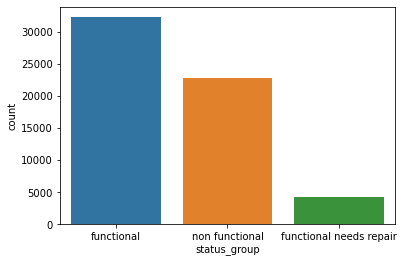

In [12]:
sns.countplot(df_train_merged['status_group']);
#plt.savefig('./functional_bar.jpeg',bbox_inches='tight', dpi=200);

In [13]:
df_train_merged['recorded_by'].value_counts()

GeoData Consultants Ltd    59400
Name: recorded_by, dtype: int64

In [14]:
#Dropped the column recorded_by since all the values were recorded by the same company.  I dropped the id since this 
# was just a way to identify individual water wells.  I also dropped date_recorded since the date the company recorded
# the information on the well is not important.
df_train_merged.drop(['id', 'recorded_by', 'date_recorded'], axis=1, inplace=True)

In [15]:
df_train_merged

,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,6000.0,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,0.0,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,25.0,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,0.0,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,0.0,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,10.0,Germany Republi,1210,CES,37.169807,-3.253847,Area Three Namba 27,0,Pangani,Kiduruni,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
59396,4700.0,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,0,Rufiji,Igumbilo,...,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional
59397,0.0,NaN,0,NaN,34.017087,-8.750434,Mashine,0,Rufiji,Madungulu,...,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,functional
59398,0.0,Malec,0,Musa,35.861315,-6.378573,Mshoro,0,Rufiji,Mwinyi,...,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional


In [16]:
are_they_equal = df_train_merged['quantity'] == df_train_merged['quantity_group']

In [17]:
are_they_equal.sum()

59400

I am dropping the quantity_group column since this is an exact replica of the quantity column.

In [18]:
df_train_merged.drop('quantity_group', axis=1, inplace=True)

In [19]:
df_train_merged

,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,...,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,6000.0,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,...,annually,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,0.0,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,...,never pay,soft,good,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,25.0,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,...,per bucket,soft,good,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,0.0,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,...,never pay,soft,good,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,0.0,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,...,never pay,soft,good,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,10.0,Germany Republi,1210,CES,37.169807,-3.253847,Area Three Namba 27,0,Pangani,Kiduruni,...,per bucket,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
59396,4700.0,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,0,Rufiji,Igumbilo,...,annually,soft,good,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional
59397,0.0,NaN,0,NaN,34.017087,-8.750434,Mashine,0,Rufiji,Madungulu,...,monthly,fluoride,fluoride,enough,machine dbh,borehole,groundwater,hand pump,hand pump,functional
59398,0.0,Malec,0,Musa,35.861315,-6.378573,Mshoro,0,Rufiji,Mwinyi,...,never pay,soft,good,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional


In [20]:
df_train_merged['num_private'].value_counts(normalize=True)

0      0.987256
6      0.001364
1      0.001229
5      0.000774
8      0.000774
         ...   
180    0.000017
213    0.000017
23     0.000017
55     0.000017
94     0.000017
Name: num_private, Length: 65, dtype: float64

In [21]:
len(df_train_merged['subvillage'].unique())

19288

Chose to drop the column num_private, because the data dictionary does not explain what this column means, and almost 99% of the data is a 0, so it will not help predict. I also chose to drop wpt_name because this has over 37,000 unique values and the highest value is none.  I am also dropping subvillage because it has over 19,000 unique values.

In [22]:
df_train_merged.drop(['wpt_name', 'num_private','subvillage'], axis=1, inplace=True)

In [23]:
df_train_merged.isna().sum()

amount_tsh                   0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
basin                        0
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group                0
quantity                     0
source                       0
source_type                  0
source_class                 0
waterpoint_type              0
waterpoi

scheme_name is almost 50% null values, I will need to decide what I want to do with this column, it's possible I just drop this column all together.  The other features that have null values are funder, installer, public_meeting, scheme_management, and permit.  Since these null values are not as frequent I need to find a way to deal with these, like using the mean, or the most frequent value.

In [24]:
df_train_merged['gps_height'].value_counts(normalize=True)

 0       0.344074
-15      0.001010
-16      0.000926
-13      0.000926
-20      0.000875
           ...   
 2285    0.000017
 2424    0.000017
 2552    0.000017
 2413    0.000017
 2385    0.000017
Name: gps_height, Length: 2428, dtype: float64

In [25]:
df_train_merged['amount_tsh'].value_counts()

0.0         41639
500.0        3102
50.0         2472
1000.0       1488
20.0         1463
            ...  
8500.0          1
6300.0          1
220.0           1
138000.0        1
12.0            1
Name: amount_tsh, Length: 98, dtype: int64

It is believable that amount_tsh has a good amount of zeros because open tanks and closed circulation water systems will have aa total static head of zero.

In [26]:
df_train['payment_type'].value_counts()

never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64

In [27]:
df_train_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59400 non-null  float64
 1   funder                 55765 non-null  object 
 2   gps_height             59400 non-null  int64  
 3   installer              55745 non-null  object 
 4   longitude              59400 non-null  float64
 5   latitude               59400 non-null  float64
 6   basin                  59400 non-null  object 
 7   region                 59400 non-null  object 
 8   region_code            59400 non-null  int64  
 9   district_code          59400 non-null  int64  
 10  lga                    59400 non-null  object 
 11  ward                   59400 non-null  object 
 12  population             59400 non-null  int64  
 13  public_meeting         56066 non-null  object 
 14  scheme_management      55523 non-null  object 
 15  sc

This is way too many unique values to OneHotEncode on, and will probably make my model too overfit so I'm dropping this column

In [28]:
len(df_train_merged['region'].unique())

21

In [29]:
len(df_train_merged['basin'].unique())

9

In [30]:
df_train_merged.describe()

,amount_tsh,gps_height,longitude,latitude,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000
mean,317.650385,668.297239,34.077427,-5.706033e+00,15.297003,5.629747,179.909983,1300.652475
std,2997.574558,693.116350,6.567432,2.946019e+00,17.587406,9.633649,471.482176,951.620547
min,0.000000,-90.000000,0.000000,-1.164944e+01,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.090347,-8.540621e+00,5.000000,2.000000,0.000000,0.000000
50%,0.000000,369.000000,34.908743,-5.021597e+00,12.000000,3.000000,25.000000,1986.000000
75%,20.000000,1319.250000,37.178387,-3.326156e+00,17.000000,5.000000,215.000000,2004.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,99.000000,80.000000,30500.000000,2013.000000


In [31]:
df_train_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59400 non-null  float64
 1   funder                 55765 non-null  object 
 2   gps_height             59400 non-null  int64  
 3   installer              55745 non-null  object 
 4   longitude              59400 non-null  float64
 5   latitude               59400 non-null  float64
 6   basin                  59400 non-null  object 
 7   region                 59400 non-null  object 
 8   region_code            59400 non-null  int64  
 9   district_code          59400 non-null  int64  
 10  lga                    59400 non-null  object 
 11  ward                   59400 non-null  object 
 12  population             59400 non-null  int64  
 13  public_meeting         56066 non-null  object 
 14  scheme_management      55523 non-null  object 
 15  sc

I decided to drop scheme_name because of the amount of nulls it has.  Using any type of Imputer would skew this data too much

In [32]:
df_train_merged.drop(['scheme_name'], axis=1, inplace=True)

In [33]:
df_train_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59400 non-null  float64
 1   funder                 55765 non-null  object 
 2   gps_height             59400 non-null  int64  
 3   installer              55745 non-null  object 
 4   longitude              59400 non-null  float64
 5   latitude               59400 non-null  float64
 6   basin                  59400 non-null  object 
 7   region                 59400 non-null  object 
 8   region_code            59400 non-null  int64  
 9   district_code          59400 non-null  int64  
 10  lga                    59400 non-null  object 
 11  ward                   59400 non-null  object 
 12  population             59400 non-null  int64  
 13  public_meeting         56066 non-null  object 
 14  scheme_management      55523 non-null  object 
 15  pe

In [34]:
len(df_train_merged['funder'].unique())

1898

In [35]:
len(df_train_merged['installer'].unique())

2146

I am dropping the funder and installer columns because these both have over 1,800 unique values. I am also dropping region because it is covered by region_code.

In [36]:
df_train_merged.drop(['funder', 'installer', 'region'], axis=1, inplace=True)

In [37]:
df_train_merged.isna().sum()

amount_tsh                  0
gps_height                  0
longitude                   0
latitude                    0
basin                       0
region_code                 0
district_code               0
lga                         0
ward                        0
population                  0
public_meeting           3334
scheme_management        3877
permit                   3056
construction_year           0
extraction_type             0
extraction_type_group       0
extraction_type_class       0
management                  0
management_group            0
payment                     0
payment_type                0
water_quality               0
quality_group               0
quantity                    0
source                      0
source_type                 0
source_class                0
waterpoint_type             0
waterpoint_type_group       0
status_group                0
dtype: int64

I now only have 3 columns with null values, public_meeting, scheme_management, and permit.

In [38]:
df_train_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59400 non-null  float64
 1   gps_height             59400 non-null  int64  
 2   longitude              59400 non-null  float64
 3   latitude               59400 non-null  float64
 4   basin                  59400 non-null  object 
 5   region_code            59400 non-null  int64  
 6   district_code          59400 non-null  int64  
 7   lga                    59400 non-null  object 
 8   ward                   59400 non-null  object 
 9   population             59400 non-null  int64  
 10  public_meeting         56066 non-null  object 
 11  scheme_management      55523 non-null  object 
 12  permit                 56344 non-null  object 
 13  construction_year      59400 non-null  int64  
 14  extraction_type        59400 non-null  object 
 15  ex

In [39]:
df_train_merged['scheme_management'].value_counts()

VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

In [40]:
df_train_merged['amount_tsh'].max()

350000.0

I realized that there some impossible outliers in the amount_tsh column.  There is no chance of a water well have 350,000 meters of total static head. I decided to drop any values that were greater than 2,500 meters.

In [41]:
mask = df_train_merged['amount_tsh'] < 2500

In [42]:
mask

0        False
1         True
2         True
3         True
4         True
         ...  
59395     True
59396    False
59397     True
59398     True
59399     True
Name: amount_tsh, Length: 59400, dtype: bool

In [43]:
df_train_merged = df_train_merged[mask]

In [44]:
df_train_merged

,amount_tsh,gps_height,longitude,latitude,basin,region_code,district_code,lga,ward,population,...,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
1,0.0,1399,34.698766,-2.147466,Lake Victoria,20,2,Serengeti,Natta,280,...,never pay,soft,good,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,25.0,686,37.460664,-3.821329,Pangani,21,4,Simanjiro,Ngorika,250,...,per bucket,soft,good,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,0.0,263,38.486161,-11.155298,Ruvuma / Southern Coast,90,63,Nanyumbu,Nanyumbu,58,...,never pay,soft,good,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,0.0,0,31.130847,-1.825359,Lake Victoria,18,1,Karagwe,Nyakasimbi,0,...,never pay,soft,good,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
5,20.0,0,39.172796,-4.765587,Pangani,4,8,Mkinga,Moa,1,...,per bucket,salty,salty,enough,other,other,unknown,communal standpipe multiple,communal standpipe,functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59394,500.0,351,37.634053,-6.124830,Wami / Ruvu,5,6,Mvomero,Diongoya,89,...,monthly,soft,good,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,non functional
59395,10.0,1210,37.169807,-3.253847,Pangani,3,5,Hai,Masama Magharibi,125,...,per bucket,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
59397,0.0,0,34.017087,-8.750434,Rufiji,12,7,Mbarali,Chimala,0,...,monthly,fluoride,fluoride,enough,machine dbh,borehole,groundwater,hand pump,hand pump,functional
59398,0.0,0,35.861315,-6.378573,Rufiji,1,4,Chamwino,Mvumi Makulu,0,...,never pay,soft,good,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional


In [45]:
df_train_merged['amount_tsh'].describe()

count    57765.000000
mean       113.281967
std        334.144676
min          0.000000
25%          0.000000
50%          0.000000
75%         20.000000
max       2400.000000
Name: amount_tsh, dtype: float64

In [46]:
df_train_merged['amount_tsh'].head()

1     0.0
2    25.0
3     0.0
4     0.0
5    20.0
Name: amount_tsh, dtype: float64

I decided that this question would have better predictions if I dropped the data where the status group was equal to functional needs repair.  I also felt like it was hard to understand how good or bad of shape these wells are in. 

In [47]:
mask2 = df_train_merged['status_group']!= "functional needs repair"

In [48]:
df_train_merged = df_train_merged[mask2]

In [49]:
df_train_merged['status_group'].value_counts().sum()

53563

In [50]:
df_train_merged

,amount_tsh,gps_height,longitude,latitude,basin,region_code,district_code,lga,ward,population,...,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
1,0.0,1399,34.698766,-2.147466,Lake Victoria,20,2,Serengeti,Natta,280,...,never pay,soft,good,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,25.0,686,37.460664,-3.821329,Pangani,21,4,Simanjiro,Ngorika,250,...,per bucket,soft,good,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,0.0,263,38.486161,-11.155298,Ruvuma / Southern Coast,90,63,Nanyumbu,Nanyumbu,58,...,never pay,soft,good,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,0.0,0,31.130847,-1.825359,Lake Victoria,18,1,Karagwe,Nyakasimbi,0,...,never pay,soft,good,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
5,20.0,0,39.172796,-4.765587,Pangani,4,8,Mkinga,Moa,1,...,per bucket,salty,salty,enough,other,other,unknown,communal standpipe multiple,communal standpipe,functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59394,500.0,351,37.634053,-6.124830,Wami / Ruvu,5,6,Mvomero,Diongoya,89,...,monthly,soft,good,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,non functional
59395,10.0,1210,37.169807,-3.253847,Pangani,3,5,Hai,Masama Magharibi,125,...,per bucket,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
59397,0.0,0,34.017087,-8.750434,Rufiji,12,7,Mbarali,Chimala,0,...,monthly,fluoride,fluoride,enough,machine dbh,borehole,groundwater,hand pump,hand pump,functional
59398,0.0,0,35.861315,-6.378573,Rufiji,1,4,Chamwino,Mvumi Makulu,0,...,never pay,soft,good,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional


I decided to create a new column called status and this column would put a 0 for non functional water wells and a 1 for functional water wells.  This new column will be my y in my test train split.

In [51]:
df_train_merged['status'] = df_train_merged.status_group.map({"non functional":0, "functional":1})

<ipython-input-51-dea2175edc95>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_merged['status'] = df_train_merged.status_group.map({"non functional":0, "functional":1})


In [52]:
df_train_merged

,amount_tsh,gps_height,longitude,latitude,basin,region_code,district_code,lga,ward,population,...,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,status
1,0.0,1399,34.698766,-2.147466,Lake Victoria,20,2,Serengeti,Natta,280,...,soft,good,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,1
2,25.0,686,37.460664,-3.821329,Pangani,21,4,Simanjiro,Ngorika,250,...,soft,good,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional,1
3,0.0,263,38.486161,-11.155298,Ruvuma / Southern Coast,90,63,Nanyumbu,Nanyumbu,58,...,soft,good,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,0
4,0.0,0,31.130847,-1.825359,Lake Victoria,18,1,Karagwe,Nyakasimbi,0,...,soft,good,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,1
5,20.0,0,39.172796,-4.765587,Pangani,4,8,Mkinga,Moa,1,...,salty,salty,enough,other,other,unknown,communal standpipe multiple,communal standpipe,functional,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59394,500.0,351,37.634053,-6.124830,Wami / Ruvu,5,6,Mvomero,Diongoya,89,...,soft,good,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,non functional,0
59395,10.0,1210,37.169807,-3.253847,Pangani,3,5,Hai,Masama Magharibi,125,...,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,1
59397,0.0,0,34.017087,-8.750434,Rufiji,12,7,Mbarali,Chimala,0,...,fluoride,fluoride,enough,machine dbh,borehole,groundwater,hand pump,hand pump,functional,1
59398,0.0,0,35.861315,-6.378573,Rufiji,1,4,Chamwino,Mvumi Makulu,0,...,soft,good,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional,1


In [53]:
df_train_merged['waterpoint_type_group'].value_counts()

communal standpipe    30583
hand pump             16110
other                  6065
improved spring         684
cattle trough           114
dam                       7
Name: waterpoint_type_group, dtype: int64

In [54]:
df_train_merged['status_group'].value_counts(normalize=True)

functional        0.578832
non functional    0.421168
Name: status_group, dtype: float64

In [55]:
df_train_merged.isna().sum()

amount_tsh                  0
gps_height                  0
longitude                   0
latitude                    0
basin                       0
region_code                 0
district_code               0
lga                         0
ward                        0
population                  0
public_meeting           3168
scheme_management        3643
permit                   2734
construction_year           0
extraction_type             0
extraction_type_group       0
extraction_type_class       0
management                  0
management_group            0
payment                     0
payment_type                0
water_quality               0
quality_group               0
quantity                    0
source                      0
source_type                 0
source_class                0
waterpoint_type             0
waterpoint_type_group       0
status_group                0
status                      0
dtype: int64

I decided to drop the nulls in the permit column and then convert this column from a boolean to an integer column.

In [56]:
df_train_merged['permit']

1         True
2         True
3         True
4         True
5         True
         ...  
59394     True
59395     True
59397    False
59398     True
59399     True
Name: permit, Length: 53563, dtype: object

In [57]:
mask3 = df_train_merged['permit'].isna()

In [58]:
df_train_merged = df_train_merged[~ mask3]

In [59]:
df_train_merged.isna().sum()

amount_tsh                  0
gps_height                  0
longitude                   0
latitude                    0
basin                       0
region_code                 0
district_code               0
lga                         0
ward                        0
population                  0
public_meeting           2903
scheme_management        3604
permit                      0
construction_year           0
extraction_type             0
extraction_type_group       0
extraction_type_class       0
management                  0
management_group            0
payment                     0
payment_type                0
water_quality               0
quality_group               0
quantity                    0
source                      0
source_type                 0
source_class                0
waterpoint_type             0
waterpoint_type_group       0
status_group                0
status                      0
dtype: int64

In [60]:
df_train_merged['permit'] = df_train_merged['permit'].astype(int)

<ipython-input-60-4b29544105b5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_merged['permit'] = df_train_merged['permit'].astype(int)


In [61]:
df_train_merged['permit']

1        1
2        1
3        1
4        1
5        1
        ..
59394    1
59395    1
59397    0
59398    1
59399    1
Name: permit, Length: 50829, dtype: int64

In [62]:
df_train_merged['permit'].value_counts(normalize=True)

1    0.68941
0    0.31059
Name: permit, dtype: float64

In [63]:
permit_df = df_train_merged.groupby('permit')['status'].mean()

In [64]:
permit_df

permit
0    0.552987
1    0.588408
Name: status, dtype: float64

I ran a heat map to check on the correlations of my integer columns.

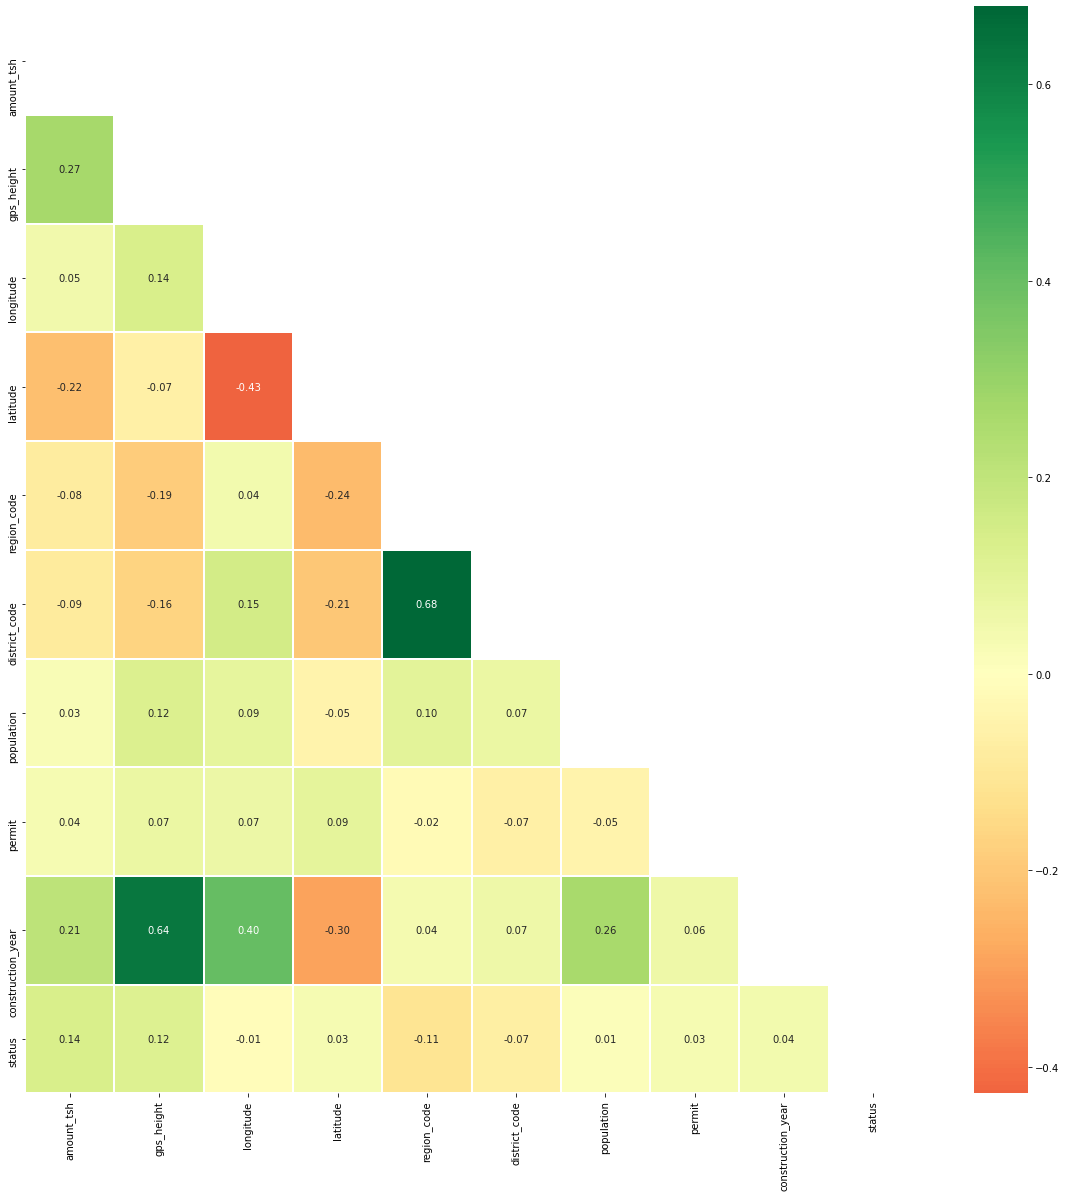

In [65]:
# Create the correlation matrix
corr = df_train_merged.corr(method = 'pearson')


mask = np.triu(np.ones_like(corr, dtype=bool))

# Add the mask to the heatmap
fig, ax = plt.subplots(figsize=(20,20)) 
ax = sns.heatmap(corr, mask=mask, cmap= "RdYlGn", center=0, linewidths=1, annot=True, fmt=".2f")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_xticklabels())
plt.show()

I am creating a DataFrame for waterpoint type group so I can graph how the values in this column relate to the status of the wells.

In [66]:
WPT = df_train_merged[['waterpoint_type_group', 'status']]

WPT

,waterpoint_type_group,status
1,communal standpipe,1
2,communal standpipe,1
3,communal standpipe,0
4,communal standpipe,1
5,communal standpipe,1
...,...,...
59394,communal standpipe,0
59395,communal standpipe,1
59397,hand pump,1
59398,hand pump,1


In [67]:
WPT['waterpoint_type_group'].value_counts()

communal standpipe    28647
hand pump             15642
other                  5768
improved spring         680
cattle trough            86
dam                       6
Name: waterpoint_type_group, dtype: int64

In [68]:
mask5 = ((WPT['waterpoint_type_group']== "improved spring") |(WPT['waterpoint_type_group']== "hand pump") | (WPT['waterpoint_type_group']== "communal standpipe") |  (WPT['waterpoint_type_group']== "other"))

In [69]:
WPT = WPT[mask5]

In [70]:
WPT['waterpoint_type_group'].value_counts()

communal standpipe    28647
hand pump             15642
other                  5768
improved spring         680
Name: waterpoint_type_group, dtype: int64

In [71]:
WPT_clean = WPT.groupby('waterpoint_type_group')['status'].mean()

In [72]:
WPT_clean

waterpoint_type_group
communal standpipe    0.618738
hand pump             0.652730
improved spring       0.801471
other                 0.138176
Name: status, dtype: float64

In [73]:
WPT_sort = sorted(WPT_clean.values)

In [74]:
WPT_list= ['other' , 'communal standpipe' , 'hand pump' , 'improved spring']

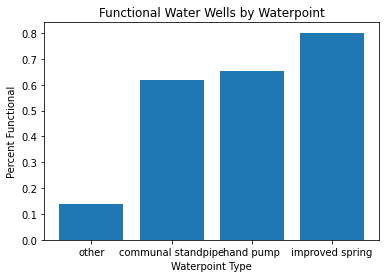

In [75]:
fig = plt.figure()


plt.bar(WPT_list,WPT_sort)
plt.title('Functional Water Wells by Waterpoint')
plt.xlabel('Waterpoint Type')
plt.ylabel('Percent Functional')
plt.grid(False)
#plt.savefig('./WaterpointType.jpeg',bbox_inches='tight', dpi=200);

Here I am creating my X and y and then running a train test split, with 80% of my data in the training data and 20% in the testing data.

## Modeling 

In [168]:
X = df_train_merged.drop(['status_group', 'status'], axis=1)
y = df_train_merged['status']

In [169]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

I am creating a function to grab my columns with floats and integers, and an equation to grab all my object columns. 

In [170]:
def grab_numeric(df):
    return df.select_dtypes(include=['float', 'int'])

In [171]:
def grab_object(df):
    return df.select_dtypes(include=['object'])

Running a functon transformer on my 2 functions.

In [172]:
GrabNumeric = FunctionTransformer(grab_numeric)

In [173]:
GrabObject = FunctionTransformer(grab_object)

In [174]:
GrabNumeric.fit(X_train)

FunctionTransformer(func=<function grab_numeric at 0x7fdf551a9790>)

Creating my pipe and subpipes.

In [175]:
pipe = Pipeline(steps=[
    ('num', GrabNumeric),
    ('ss', StandardScaler())
])


In [176]:
subpipe_num = Pipeline(steps=[('num_impute', SimpleImputer()),
                              ('ss', StandardScaler())])


subpipe_cat = Pipeline(steps=[('cat_impute', SimpleImputer(strategy='most_frequent')),
                              ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

In [177]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40663 entries, 57746 to 18478
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             40663 non-null  float64
 1   gps_height             40663 non-null  int64  
 2   longitude              40663 non-null  float64
 3   latitude               40663 non-null  float64
 4   basin                  40663 non-null  object 
 5   region_code            40663 non-null  int64  
 6   district_code          40663 non-null  int64  
 7   lga                    40663 non-null  object 
 8   ward                   40663 non-null  object 
 9   population             40663 non-null  int64  
 10  public_meeting         38341 non-null  object 
 11  scheme_management      37786 non-null  object 
 12  permit                 40663 non-null  int64  
 13  construction_year      40663 non-null  int64  
 14  extraction_type        40663 non-null  object 
 15

Creating my Column Transformer.

In [182]:
ct = ColumnTransformer(transformers= [
    ('subpipe_num' , subpipe_num, [0,1,2,3,5,6,9,12]),
    ('subpipe_cat' , subpipe_cat, [7,8,10,11,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28]),
    
    
])

Fitting and transforming my data on my X_train

In [81]:
pd.DataFrame(ct.fit_transform(X_train))

,0,1,2,3,4,5,6,7,8,9,...,2309,2310,2311,2312,2313,2314,2315,2316,2317,2318
0,-0.341056,-0.928923,-0.131048,1.007250,0.186240,-0.189282,-0.397723,0.669335,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-0.195408,-0.956436,0.798457,-0.392786,-0.472151,-0.288886,-0.364361,-1.494020,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,-0.341056,-0.928923,-0.096663,0.845068,0.076508,-0.388490,-0.397723,-1.494020,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.341056,-0.216482,0.570273,-1.422941,3.533061,3.695267,0.158304,0.669335,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.341056,-0.928923,-0.209080,-1.232399,-0.197821,0.009925,-0.397723,-1.494020,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40658,0.241537,1.386509,0.153005,-1.198642,-0.252687,-0.189282,0.047099,0.669335,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
40659,-0.341056,-0.962228,0.805744,-0.401543,-0.472151,-0.288886,-0.075227,-1.494020,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
40660,-0.341056,-0.928923,-0.317284,1.130293,0.186240,-0.089678,-0.397723,0.669335,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
40661,0.387186,1.111380,-0.641667,0.451145,0.021643,-0.388490,0.981224,0.669335,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Creating a class ModelWithCV that will be used to see cross validiation scores of our models.

In [82]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

### Dummy Model

In [83]:
dummy_model_pipe = Pipeline(steps = [
    ('ct', ct),
    ('dummy_model' , DummyClassifier(strategy = 'most_frequent'))
])

In [84]:
dummy_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [0, 1, 2, 3, 5, 6, 9, 12]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                        

This score below will be our baseline on which we are trying to improve through our next models.

In [85]:
dummy_model_pipe.score(X_train, y_train)

0.5771831886481568

In [86]:
dummy_pipe = ModelWithCV(dummy_model_pipe, 'dummy', X_train, y_train)

<AxesSubplot:title={'center':'CV Results for `dummy` Model'}>

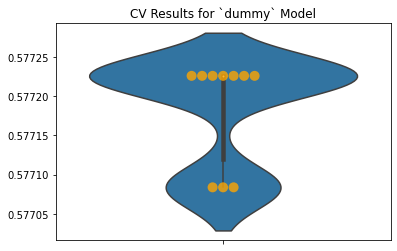

In [87]:
fig, ax = plt.subplots()

dummy_pipe.plot_cv(ax=ax)

In [229]:
dummy_model_filename = 'Pickles/dummy_model.sav'

In [228]:
pickle.dump(dummy_pipe, open(dummy_model_filename, 'wb'))

In [ ]:
# dummy_model_pickle = pickle.load(open('dummy_model.sav', 'rb'))

### Logistic Regression First Simple Model

I chose Logistic Regression for my first model because will help me understand the relationship between my dependent and independent variables by estimating probabilities.

In [89]:
logreg_model_pipe= Pipeline(steps=[
    ('ct', ct),
    ('logreg', LogisticRegression(random_state=42))
])

In [90]:
logreg_model_pipe.fit(X_train, y_train)

/Users/jordan/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [0, 1, 2, 3, 5, 6, 9, 12]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                        

In [92]:
log_pipe = ModelWithCV(logreg_model_pipe, model_name = 'log_pipe', X=X_train, y=y_train)

/Users/jordan/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jordan/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

In [93]:
log_pipe.print_cv_summary()

CV Results for `log_pipe` model:
            0.82321 ± 0.00420 accuracy
        


<AxesSubplot:title={'center':'CV Results for `log_pipe` Model'}>

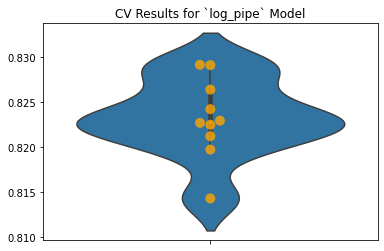

In [94]:
fig, ax = plt.subplots()

log_pipe.plot_cv(ax=ax)

In [230]:
logreg_model_filename = 'Pickles/logreg_model.sav'

In [231]:
pickle.dump(log_pipe, open(logreg_model_filename, 'wb'))

In [ ]:
# logreg_model_pickle = pickle.load(open('logreg_model.sav', 'rb'))

### GridSearch with Logistic Regression

Next I chose to run a simple gridsearch where my only parameter is increasing the maximum iterations, from the default of 100 to 1,000. 

In [95]:
logreg_params = {}
logreg_params['logreg__max_iter'] = [1000]



In [ ]:
logreg_grid = GridSearchCV(logreg_model_pipe, param_grid = logreg_params, cv = 3, verbose = 3)

In [97]:
logreg_grid.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END .............logreg__max_iter=1000;, score=0.823 total time=  37.6s
[CV 2/3] END .............logreg__max_iter=1000;, score=0.822 total time=  34.4s
[CV 3/3] END .............logreg__max_iter=1000;, score=0.819 total time=  37.0s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         [0, 1,
                                                                          2, 3,
                                                                          5, 6,
                                                                          9,
                                                                          12]),
                               

In [233]:
logreg_grid.best_score_

0.8214592681457548

In [4]:
logreg_grid_filename = 'Pickles/logreg_grid.sav'

In [ ]:
pickle.dump(logreg_grid, open(logreg_grid_filename, 'wb'))

In [ ]:
# logreg_model_pickle = pickle.load(open('logreg_model.sav', 'rb'))

### Random Forest Model

I chose to run a Random Forest Model next because it works well with high dimensionality and with a lot of data.  

In [100]:
rf_class = RandomForestClassifier(random_state=42)

rf_model_pipe = Pipeline([('ct', ct), ('rfc', rf_class)])

In [101]:
rf_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [0, 1, 2, 3, 5, 6, 9, 12]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                        

In [102]:
rf_model = ModelWithCV(rf_model_pipe, 'forest_pipe', X_train, y_train)

<AxesSubplot:title={'center':'CV Results for `forest_pipe` Model'}>

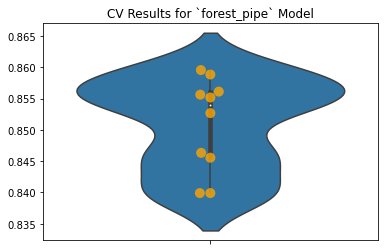

In [106]:
fig, ax = plt.subplots()

rf_model.plot_cv(ax=ax)

In [108]:
rf_model.print_cv_summary()

CV Results for `forest_pipe` model:
            0.85097 ± 0.00708 accuracy
        


In [1]:
rf_model_filename = 'Pickles/rf_model.sav'

In [ ]:
pickle.dump(rf_model, open(rf_model_filename, 'wb'))

In [ ]:
# rf_model_pickle = pickle.load(open('rf_model.sav', 'rb'))

### XGBoost Classification - Best Model

Next I chose to run an XGBoost Classifier.  I chose this because this is similar to a Random Forest, but uses a different training algorithm.  This felt like an appropriate choice because my Random Forest model had the highest score so far.

In [114]:
xgb_class = xgboost.XGBClassifier(random_state=42, objective='binary:logistic')

In [116]:
xgb_model_pipe = Pipeline ([('ct', ct), ('xgb', xgb_class)])

In [121]:
xgb = xgb_model_pipe.fit(X_train, y_train)

In [122]:
def scoring(estimator, X, y):
    '''
    Prints the accuracy, precision, and recall of the given fitted estimator and data.
    
    Prints the confusion matrix.
    '''
    p_score = precision_score(y, estimator.predict(X))
    r_score = recall_score(y, estimator.predict(X))
    
    print(f'Accuracy: {estimator.score(X, y)}')
    print(f'Precision: {p_score}')
    print(f'Recall: {r_score}')
    
    plot_confusion_matrix(estimator, X, y)

Accuracy: 0.8612497848166638
Precision: 0.8390642829973374
Recall: 0.9398806987643801


/Users/jordan/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


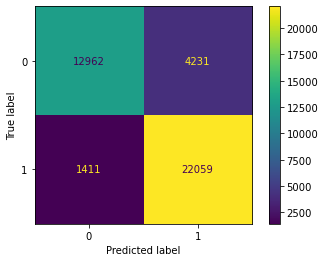

In [124]:
scoring(xgb, X_train, y_train)

As you can see in the confusion matrix above, my model predicts true negatives much more accurately than it predicts true positives.

Accuracy: 0.8492032264410782
Precision: 0.8327718223583461
Recall: 0.9249872427283552


/Users/jordan/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


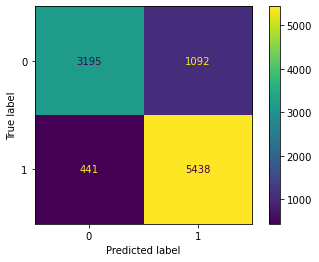

In [143]:
scoring(xgb, X_test, y_test)

In [238]:
xgb_model_filename = 'Pickles/xgb_model.sav'

In [239]:
pickle.dump(xgb, open(xgb_model_filename, 'wb'))

In [ ]:
# rf_model_pickle = pickle.load(open('xgb_model.sav', 'rb'))

### GridSearch with XGBoost

I decided to run a GridSearch on my XGBoost model.  I tuned the max_depth, n_estimators, and learning_rate parameters to see if I could improve my model from the default values of XGBoost. The default parameters are max_depth=3 , n_estimators =100, and learning_rate = .1

In [136]:
xgb_gs_class = xgboost.XGBClassifier(random_state=42, objective='binary:logistic')

In [137]:
xgb_gs_model_pipe = Pipeline ([('ct', ct), ('xgb', xgb_gs_class)])

In [138]:
xgbparameters = {
    'xgb__max_depth': (2, 5, 10),
    'xgb__n_estimators': (60, 150, 240),
    'xgb__learning_rate': [0.1, 0.01, 0.05]
}

In [139]:
xgb_grid_search = GridSearchCV(
    estimator=xgb_gs_model_pipe,
    param_grid=xgbparameters,
    scoring = 'accuracy',
    cv = 3,
    verbose= 3
)

In [140]:
xgb = xgb_grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV 1/3] END xgb__learning_rate=0.1, xgb__max_depth=2, xgb__n_estimators=60;, score=0.774 total time=  35.0s
[CV 2/3] END xgb__learning_rate=0.1, xgb__max_depth=2, xgb__n_estimators=60;, score=0.766 total time=  27.6s
[CV 3/3] END xgb__learning_rate=0.1, xgb__max_depth=2, xgb__n_estimators=60;, score=0.767 total time=  23.6s
[CV 1/3] END xgb__learning_rate=0.1, xgb__max_depth=2, xgb__n_estimators=150;, score=0.787 total time=  55.9s
[CV 2/3] END xgb__learning_rate=0.1, xgb__max_depth=2, xgb__n_estimators=150;, score=0.784 total time=  56.2s
[CV 3/3] END xgb__learning_rate=0.1, xgb__max_depth=2, xgb__n_estimators=150;, score=0.782 total time=  53.5s
[CV 1/3] END xgb__learning_rate=0.1, xgb__max_depth=2, xgb__n_estimators=240;, score=0.794 total time= 1.3min
[CV 2/3] END xgb__learning_rate=0.1, xgb__max_depth=2, xgb__n_estimators=240;, score=0.795 total time= 1.3min
[CV 3/3] END xgb__learning_rate=0.1, xgb__max_depth=2, xgb__n_

[CV 3/3] END xgb__learning_rate=0.05, xgb__max_depth=10, xgb__n_estimators=60;, score=0.827 total time= 1.4min
[CV 1/3] END xgb__learning_rate=0.05, xgb__max_depth=10, xgb__n_estimators=150;, score=0.837 total time= 3.5min
[CV 2/3] END xgb__learning_rate=0.05, xgb__max_depth=10, xgb__n_estimators=150;, score=0.838 total time= 3.5min
[CV 3/3] END xgb__learning_rate=0.05, xgb__max_depth=10, xgb__n_estimators=150;, score=0.833 total time= 3.5min
[CV 1/3] END xgb__learning_rate=0.05, xgb__max_depth=10, xgb__n_estimators=240;, score=0.842 total time= 5.7min
[CV 2/3] END xgb__learning_rate=0.05, xgb__max_depth=10, xgb__n_estimators=240;, score=0.842 total time= 5.6min
[CV 3/3] END xgb__learning_rate=0.05, xgb__max_depth=10, xgb__n_estimators=240;, score=0.835 total time= 5.6min


In [141]:
xgb.best_score_

0.8437153853267341

The XGBoost GridSearch accuracy score did not beat the XGBoost with default values.

In [142]:
xgb.best_params_

{'xgb__learning_rate': 0.1, 'xgb__max_depth': 10, 'xgb__n_estimators': 240}

In [240]:
xgb_grid_model_filename = 'Pickles/xgb_grid_model.sav'

In [241]:
pickle.dump(xgb_grid_search, open(xgb_grid_model_filename, 'wb'))

In [ ]:
# rf_model_pickle = pickle.load(open('xgb_grid_model.sav', 'rb'))

### Next Steps 

Need to run another GridSearch and raise my max_depth and n_estimators learning_rate. Unfortunately time did not allow me to do this.